In [1]:
import numpy as np
import torch
import os

def generate_sine_wave(shape, frequency, amplitude, phase):
    
    """Generate a 3D sine wave pattern."""
    x = np.linspace(0, 2 * np.pi, shape[0])
    y = np.linspace(0, 2 * np.pi, shape[1])
    z = np.linspace(0, 2 * np.pi, shape[2])
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    sine_wave = amplitude * np.sin(frequency * (X + Y + Z) + phase)
    return sine_wave

def generate_linear_gradient(shape, start, end):

    """Generate a 3D linear gradient pattern."""
    gradient = np.linspace(start, end, num=shape[0])
    gradient = np.expand_dims(np.tile(gradient, (shape[1], shape[2], 1)).T,-1)
    gradient = np.repeat(gradient, 2, axis=-1)
    return gradient

def add_noise(data, noise_level):

    """Add random noise to the data."""
    noise = noise_level * np.random.randn(*data.shape)
    return data + noise

def generate_synthetic_data(shape, num_samples, noise_level=0.2):

    """Generate synthetic 3D CFD data with regular patterns and variations."""
    data = []
    for _ in range(num_samples):
        frequency = np.random.uniform(1.0, 64.0)  # Random frequency between 1 and 64
        amplitude = np.random.uniform(0.0, 1.0)  # Random amplitude between 0.5 and 2.0
        phase = np.random.rand() * 2 * np.pi     # Random phase between 0 and 2*pi
        sine_wave = np.expand_dims(generate_sine_wave(shape, frequency, amplitude, phase),-1)
        cosine_wave = np.expand_dims(generate_sine_wave(shape, frequency, amplitude, phase + np.pi/2), -1)
        wave = np.concatenate((sine_wave, cosine_wave), axis=-1)
        gradient = generate_linear_gradient(wave.shape, start=0, end=1)
        combined_pattern = wave + gradient
        noisy_pattern = add_noise(combined_pattern, noise_level)
        data.append(noisy_pattern)
        
    return np.array(data)

def save_data_as_pt(data, directory, prefix):

    """Save the generated data as .pt files."""
    if not os.path.exists(directory):
        os.makedirs(directory)
    for i, sample in enumerate(data):
        tensor = torch.from_numpy(sample).float()
        torch.save(tensor, os.path.join(directory, f"{prefix}_{i}.pt"))

# Parameters
shape = (21, 21, 21)
num_samples = 100
noise_level = 0.1
output_directory = "synthetic_cfd_data"
file_prefix = "sample"

# Generate and save data
synthetic_data = generate_synthetic_data(shape, num_samples, noise_level)
save_data_as_pt(synthetic_data, output_directory, file_prefix)

print(f"Generated and saved {num_samples} samples in '{output_directory}' directory.")

Generated and saved 100 samples in 'synthetic_cfd_data' directory.


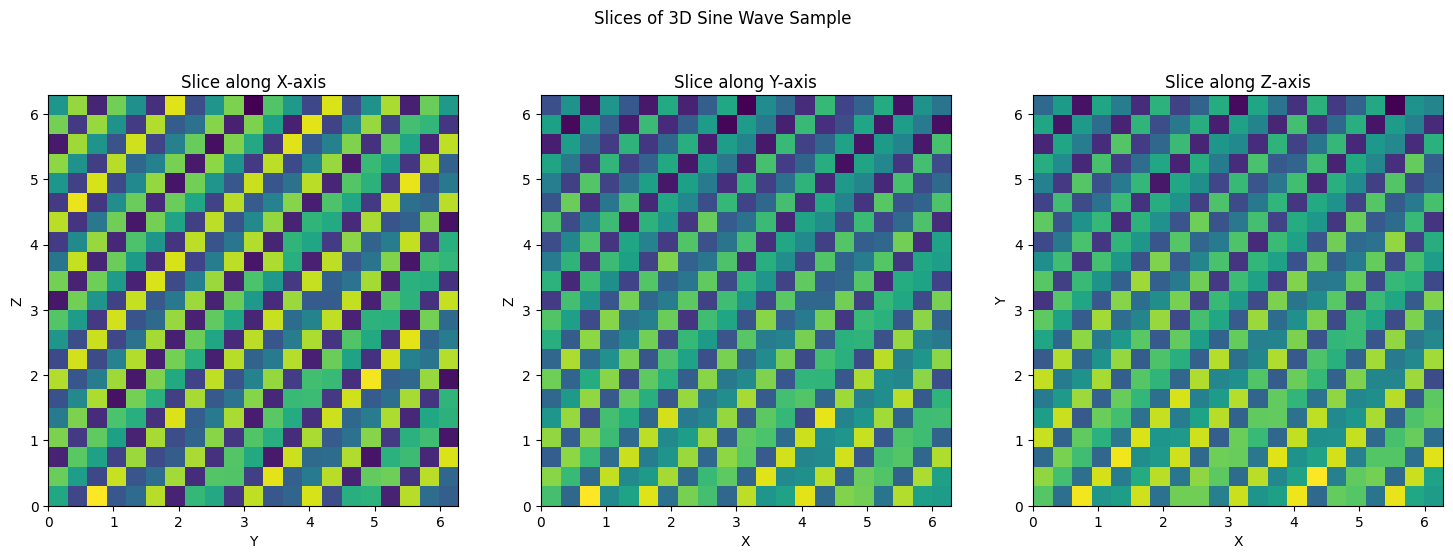

In [2]:
import matplotlib.pyplot as plt

# Select the first sample
sample = synthetic_data[90]

# Plot the sample
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Create a grid for the plot
x = np.linspace(0, 2 * np.pi, shape[0])
y = np.linspace(0, 2 * np.pi, shape[1])
z = np.linspace(0, 2 * np.pi, shape[2])
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# Plot slices of the 3D volume
slices = [shape[0] // 2, shape[1] // 2, shape[2] // 2]
axes[0].imshow(sample[slices[0], :, :,1], cmap='viridis', extent=(0, 2 * np.pi, 0, 2 * np.pi))
axes[0].set_title('Slice along X-axis')
axes[0].set_xlabel('Y')
axes[0].set_ylabel('Z')

axes[1].imshow(sample[:, slices[1], :, 1], cmap='viridis', extent=(0, 2 * np.pi, 0, 2 * np.pi))
axes[1].set_title('Slice along Y-axis')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Z')

axes[2].imshow(sample[:, :, slices[2],1], cmap='viridis', extent=(0, 2 * np.pi, 0, 2 * np.pi))
axes[2].set_title('Slice along Z-axis')
axes[2].set_xlabel('X')
axes[2].set_ylabel('Y')

plt.suptitle('Slices of 3D Sine Wave Sample')
plt.show()

[INFO] started instantiating 3D CFD pytorch dataset
C:\Users\apost\OneDrive\Documents\GitHub\Convolutional-VAE-for-3D-Turbulence-Data\synthetic_cfd_data


c:\Users\apost\OneDrive\Documents\GitHub\Convolutional-VAE-for-3D-Turbulence-Data\datasets.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_cube = torch.load(data_f

torch.Size([2, 21, 21, 21])
Sample 30 shape: torch.Size([2, 21, 21, 21])


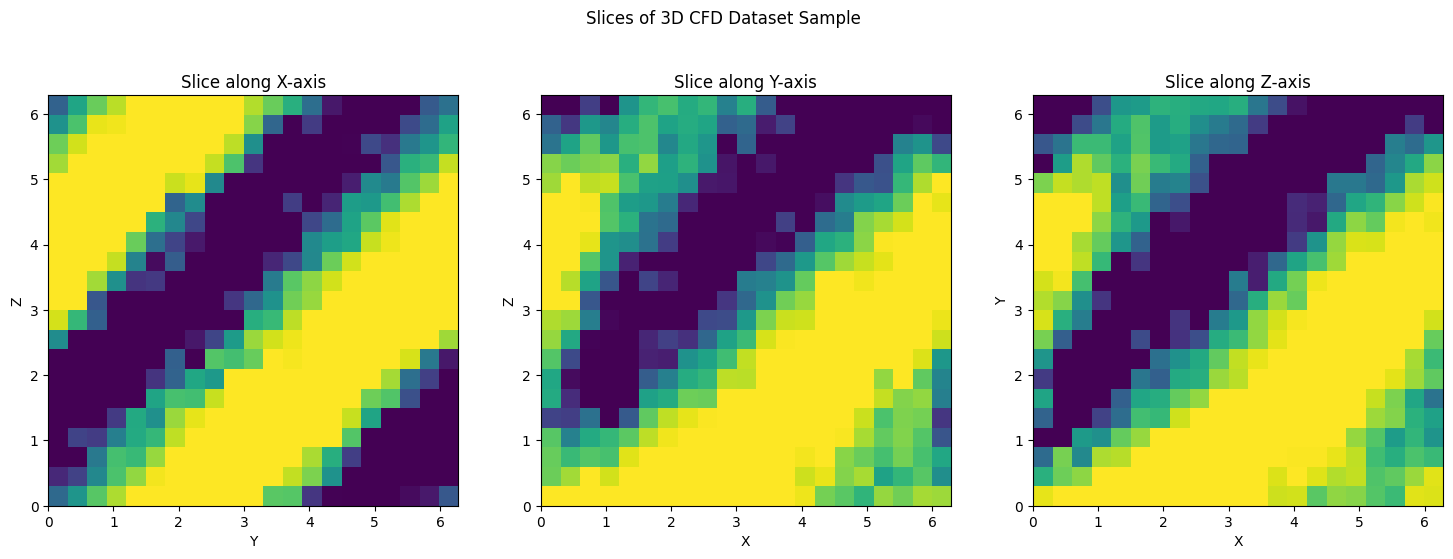

In [3]:
from datasets import CFD3DDataset 

# Define a custom transform (if needed)
def custom_transform(sample):
    # Example transform: normalize the sample
    return (sample - np.mean(sample)) / np.std(sample)

# Initialize the dataset
data_directory = output_directory  # Use the directory where synthetic data is saved
no_simulations = num_samples       # Number of samples generated
simulation_timesteps = 1           # Assuming each sample is a single timestep

# Create an instance of the CFD3DDataset
dataset = CFD3DDataset(data_directory=r'C:\Users\apost\OneDrive\Documents\GitHub\Convolutional-VAE-for-3D-Turbulence-Data\synthetic_cfd_data',
                       no_simulations=no_simulations, 
                       simulation_timesteps=simulation_timesteps, 
                       transforms=custom_transform)

# Access a sample from the dataset
sample_idx = 30
sample = dataset[sample_idx]
print(sample.shape)

# Print the shape of the sample
print(f"Sample {sample_idx} shape: {sample.shape}")

# If the sample is a tensor, convert it to a numpy array for visualization
if isinstance(sample, torch.Tensor):
    sample = sample.numpy()[0]

# Plot the sample
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot slices of the 3D volume
slices = [shape[0] // 2, shape[1] // 2, shape[2] // 2]
axes[0].imshow(sample[slices[0], :, :], cmap='viridis', extent=(0, 2 * np.pi, 0, 2 * np.pi))
axes[0].set_title('Slice along X-axis')
axes[0].set_xlabel('Y')
axes[0].set_ylabel('Z')

axes[1].imshow(sample[:, slices[1], :], cmap='viridis', extent=(0, 2 * np.pi, 0, 2 * np.pi))
axes[1].set_title('Slice along Y-axis')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Z')

axes[2].imshow(sample[:, :, slices[2]], cmap='viridis', extent=(0, 2 * np.pi, 0, 2 * np.pi))
axes[2].set_title('Slice along Z-axis')
axes[2].set_xlabel('X')
axes[2].set_ylabel('Y')

plt.suptitle('Slices of 3D CFD Dataset Sample')
plt.show()
